# Armball Goal Babbling with Engineered States

In this notebook, we assess performances of goal babbling for exploration using engineered representations. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Circle
from explauto.environment.dynamic_environment import DynamicEnvironment
from explauto.environment.modular_environment import FlatEnvironment, HierarchicalEnvironment
from explauto.utils import bounds_min_max
from explauto.environment.environment import Environment
from explauto.environment.simple_arm.simple_arm import joint_positions
from explauto.utils.utils import rand_bounds

## Defining the Environment

In [2]:
def arm_lengths(n_joints):
    if n_joints == 3:
        return [0.5, 0.3, 0.2]
    elif n_joints == 7:
        return [0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]
    else:
        return [1./n_joints] * n_joints
    
class Arm(Environment):
    use_process = True
    def __init__(self, m_mins, m_maxs, s_mins, s_maxs,
                 lengths, angle_shift, rest_state):
        
        Environment.__init__(self, m_mins, m_maxs, s_mins, s_maxs)

        self.lengths = lengths
        self.angle_shift = angle_shift
        self.rest_state = rest_state
        self.reset()
        
    def reset(self):
        self.logs = []
        self.lines = None
        
    def compute_motor_command(self, m):
        return bounds_min_max(m, self.conf.m_mins, self.conf.m_maxs)

    def compute_sensori_effect(self, m):
        a = self.angle_shift + np.cumsum(np.array(m))
        a_pi = np.pi * a 
        hand_pos = np.array([np.sum(np.cos(a_pi)*self.lengths), np.sum(np.sin(a_pi)*self.lengths)])
        angle = np.mod(a[-1] + 1, 2) - 1
        self.logs.append(m)
        return [hand_pos[0], hand_pos[1], angle]    
        
    def plot(self, ax, i, **kwargs_plot):
        m = self.logs[i]
        angles = np.array(m)
        angles[0] += self.angle_shift
        x, y = joint_positions(angles, self.lengths, 'std')
        x, y = [np.hstack((0., a)) for a in x, y]
        l = []
        l += ax.plot(x, y, 'grey', lw=4, animated=True, **kwargs_plot)
        l += ax.plot(x[0], y[0], 'sk', ms=8, animated=True, **kwargs_plot)
        for i in range(len(self.lengths)-1):
            l += ax.plot(x[i+1], y[i+1], 'ok', ms=8, animated=True, **kwargs_plot)
        l += ax.plot(x[-1], y[-1], 'or', ms=8, animated=True, **kwargs_plot)
        self.lines = l
        return l 
        
    def plot_update(self, ax, i, **kwargs_plot):
        if self.lines is None:
            self.plot(ax, 0, **kwargs_plot)
        m = self.logs[i]
        angles = np.array(m)
        angles[0] += self.angle_shift
        x, y = joint_positions(angles, self.lengths, 'std')
        x, y = [np.hstack((0., a)) for a in x, y]
        l = []
        l += [[x, y]]
        l += [[x[0], y[0]]]
        for i in range(len(self.lengths)-1):
            l += [[x[i+1], y[i+1]]]
        l += [[x[-1], y[-1]]]
        for (line, data) in zip(self.lines, l):
            line.set_data(data[0], data[1])
        return self.lines

        
class Ball(Environment):
    
    def __init__(self, m_mins, m_maxs, s_mins, s_maxs,
                 size, initial_position, ball_type="magnetic", color='y', random_ball_noise=0.2):
        
        Environment.__init__(self, m_mins, m_maxs, s_mins, s_maxs)

        self.ball_type = ball_type
        self.size = size
        self.size_sq = size * size
        self.color = color
        self.initial_position = initial_position
        self.random_ball_noise = random_ball_noise
        self.reset()
    
    def reset(self):
        self.move = False
        self.circle = None
        self.pos = np.array(self.initial_position)
        self.logs = []
        
    def compute_motor_command(self, m):
        return m

    def compute_sensori_effect(self, m):
        if self.ball_type == "magnetic":
            if self.move or ((m[0] - self.pos[0]) ** 2 + (m[1] - self.pos[1]) ** 2 < self.size_sq):
                self.pos = m[0:2]
                self.move = 1
        elif self.ball_type == "random":
            self.pos = self.pos + np.random.randn(2) * self.random_ball_noise
             
        self.logs.append([self.pos,
                          self.move])
        return list(self.pos)
    
    def plot(self, ax, i, **kwargs_plot):
        self.logs = self.logs[-50:]
        pos = self.logs[i][0]     
        self.circle = Circle((pos[0], pos[1]), self.size, fc=self.color, animated=True, **kwargs_plot)
        ax.add_patch(self.circle)  
        return [self.circle]
        
    def plot_update(self, ax, i, **kwargs_plot):
        if self.circle is None:
            self.plot(ax, 0, **kwargs_plot)
        self.logs = self.logs[-50:]
        pos = self.logs[i][0]    
        self.circle.center = tuple(pos)
        return [self.circle]
        
        
class ArmBall(DynamicEnvironment):
    def __init__(self, n_joints=3, n_dmp_basis=3, goal_size=1.):
        
        arm_config = dict(
            m_mins=[-1.] * n_joints,
            m_maxs=[1.] * n_joints, 
            s_mins=[-1.] * 3,
            s_maxs=[1.] * 3, 
            lengths=arm_lengths(n_joints), 
            angle_shift=0.5,
            rest_state=[0.] * n_joints)
        
        ball_config = dict(
            m_mins=[-1.] * 2,
            m_maxs=[1.] * 2, 
            s_mins=[-1.] * 2,
            s_maxs=[1.] * 2,
            size=0.1,
            initial_position=[0.6, 0.3],
            color="b")
        
        arm_ball_cfg = dict(
            m_mins=[-1.] * n_joints,
            m_maxs=[1.] * n_joints,
            s_mins=[-1.] * 2,
            s_maxs=[1.] * 2,
            top_env_cls=Ball, 
            lower_env_cls=Arm, 
            top_env_cfg=ball_config, 
            lower_env_cfg=arm_config, 
            fun_m_lower= lambda m:m,
            fun_s_lower=lambda m,s:s[0:2],
            fun_s_top=lambda m,s_lower,s:s)
        
        dynamic_environment_config = dict(
            env_cfg=arm_ball_cfg,
            env_cls=HierarchicalEnvironment,
            m_mins=[-1.] * n_joints * n_dmp_basis, 
            m_maxs=[1.] * n_joints * n_dmp_basis, 
            s_mins=[-goal_size] * 2,
            s_maxs=[goal_size] * 2,
            n_bfs=n_dmp_basis,
            move_steps=50, 
            n_dynamic_motor_dims=n_joints,
            n_dynamic_sensori_dims=2,
            sensori_traj_type="end_point",
            max_params=1000)
        
        DynamicEnvironment.__init__(self, **dynamic_environment_config)
        
        
        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax
        
    def random_motor(self): return self.random_motors()[0]
    
    
    def plot_frame(self, i):
        self.ax.cla()
        self.env.lower_env.plot(self.ax, i) # Plot Arm
        self.env.top_env.plot(self.ax, i) # Plot Ball
        self.ax.set_aspect('equal')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        
    def fig2data(self):
        """
        @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
        @param fig a matplotlib figure
        @return a numpy 3D array of RGBA values
        """
        # draw the renderer
        self.fig.canvas.draw ( )

        # Get the RGBA buffer from the figure
        w,h = self.fig.canvas.get_width_height()
        buf = np.fromstring (self.fig.canvas.tostring_argb(), dtype=np.uint8 )
        buf.shape = ( w, h,4 )

        # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
        buf = np.roll ( buf, 3, axis = 2 )
        return buf
    
    def compute_sensori_effect(self, m_traj):
        s = self.env.update(m_traj, reset=False, log=False)
        self.s_traj = s
        self.plot_frame(self.end_point-1)
        x = self.fig2data()
        
        z = s[-1]
        
        return bounds_min_max(z, self.conf.s_mins, self.conf.s_maxs)    

## Random Motor Action

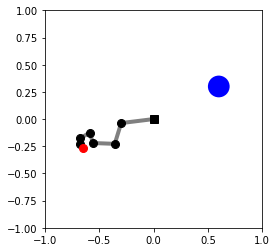

In [3]:
n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 10.   # Size of the 2D goal space

environment = ArmBall(n_joints, n_dmp_basis, goal_size)

m = environment.random_motor()
s = environment.update(m)

## Goal Babbling

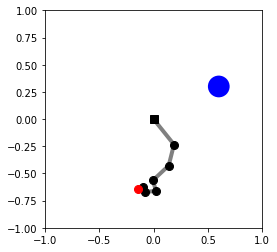

In [4]:
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto.utils import rand_bounds

n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 10.   # Size of the 2D goal space

ball_list = []
z_list = []

environment = ArmBall(n_joints, n_dmp_basis, goal_size)


# Parameters to change:
iterations = 200 # Number of iterations
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)

# Initialization of the sensorimotor model
sm_model = NonParametric(environment.conf, sigma_explo_ratio=sigma_explo_ratio, fwd='NN', inv='NN')

for i in range(iterations):
    if i < 100 or np.random.random() < 0.2: 
        # Do random motor babbling in first 100 iterations and then in 20% of the iterations
        m = environment.random_motors()[0]
    else:
        # Sample a random goal in the sensory space:
        
        s_goal = rand_bounds(environment.conf.s_bounds)[0]
        #s_goal = representation.random_z() # TODO ALEX
        
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm (plus exploration noise):
        m = sm_model.inverse_prediction(s_goal)
        
    s = environment.update(m) # observe the sensory effect s=(x, y): the last position of the ball
    
    ball_list += [environment.s_traj[-1]] # ball positions at the end of movements
    z_list += [s] # latent representation of ball position
    
    sm_model.update(m, s) # update sensorimotor model
    

## Performance

In [5]:
# Measure of exploration: discretize as a grid of size gs, count reached cells
def compute_explo(data, mins, maxs, gs=10):
    n = len(mins)
    if len(data) == 0:
        return 0
    else:
        assert len(data[0]) == n
        epss = (maxs - mins) / gs
        grid = np.zeros([gs] * n)
        for i in range(len(data)):
            idxs = np.array((data[i] - mins) / epss, dtype=int)
            idxs[idxs>=gs] = gs-1
            idxs[idxs<0] = 0
            grid[tuple(idxs)] = grid[tuple(idxs)] + 1
        grid[grid > 1] = 1
    return np.sum(grid)

In [6]:
compute_explo(ball_list, np.array([-1., -1.]), np.array([1., 1.]))

19.0

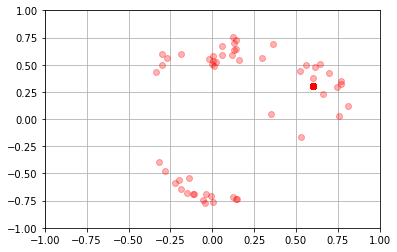

In [7]:
fig, ax = plt.subplots()
for ball in ball_list:
    ax.plot(ball[0], ball[1], "ro", lw=2, alpha=0.3)
        
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()